# CREMA-D Dataset - Emotion Recognition Model Evaluation

This notebook evaluates emotion recognition models trained on the **CREMA-D Dataset** (Crowd-sourced Emotional Multimodal Actors Dataset).

## Dataset Information
- **Emotions**: 6 categories (angry, disgust, fear, happy, neutral, sad)
- **Samples**: 7,442 audio clips from 91 actors

## Models Evaluated
- **Baseline CNN** (audio only)
- **Multimodal CNN** (audio and text)

Results and figures are saved to `results/` and `figures/` folders.

## 1. Setup and Configuration

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import (
    confusion_matrix, classification_report, 
    roc_curve, auc, precision_recall_curve,
    accuracy_score, precision_score, recall_score, f1_score
)
from sklearn.preprocessing import label_binarize
from itertools import cycle
import warnings

# Configuration for CREMA-D
RESULTS_DIR = 'results'
FIGURES_DIR = 'figures'
EMOTIONS = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad']
DATASET_NAME = 'CREMA-D'

# Create figures directory
os.makedirs(FIGURES_DIR, exist_ok=True)

# Settings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print(f"Evaluating: {DATASET_NAME} Dataset")
print(f"Results directory: {RESULTS_DIR}")
print(f"Figures directory: {FIGURES_DIR}")
print(f"Number of emotions: {len(EMOTIONS)}")


Evaluating: CREMA-D Dataset
Results directory: results
Figures directory: figures
Number of emotions: 6


In [2]:
# Check if required files exist
required_files = [
    f'{RESULTS_DIR}/baseline_cnn.h5',
    f'{RESULTS_DIR}/multimodal_cnn.h5',
    f'{RESULTS_DIR}/test_data.npz'
]

missing_files = [f for f in required_files if not os.path.exists(f)]

if missing_files:
    print(f"Missing required files for {DATASET_NAME}:")
    for f in missing_files:
        print(f"  - {f}")
    print("\nPlease run the training script first:")
    print("  python train.py")
else:
    print(f"All required files found for {DATASET_NAME}")

All required files found for CREMA-D


## 2. Load Models and Test Data

In [3]:
# Check content of test data file
test_data_path = f'{RESULTS_DIR}/test_data.npz'
if os.path.exists(test_data_path):
    temp_data = np.load(test_data_path)
    print(f"Keys in {test_data_path}:", list(temp_data.keys()))
    temp_data.close()
else:
    print(f"{test_data_path} not found")

Keys in results/test_data.npz: ['X_audio_test', 'X_text_test', 'y_test']


In [4]:
# Load test data
print(f"\nLoading {DATASET_NAME} test data...")

test_data = np.load(f'{RESULTS_DIR}/test_data.npz')
X_test_audio = test_data['X_audio_test']
X_test_text = test_data['X_text_test']
y_test = test_data['y_test']

# Reshape audio data for CNN input
if len(X_test_audio.shape) == 2:
    X_test_audio = X_test_audio.reshape(X_test_audio.shape[0], X_test_audio.shape[1], 1)

print(f"\n{DATASET_NAME} Test Data:")
print(f"Test samples: {len(y_test)}")
print(f"Audio features shape: {X_test_audio.shape}")
print(f"Text features shape: {X_test_text.shape}")
print(f"Number of emotions: {len(EMOTIONS)}")

print(f"\nEmotion distribution:")
emotion_counts = pd.Series(y_test).value_counts().sort_index()
for idx, count in emotion_counts.items():
    print(f"{EMOTIONS[idx]:12s}: {count:4d} samples ({count/len(y_test)*100:.1f}%)")


Loading CREMA-D test data...

CREMA-D Test Data:
Test samples: 1489
Audio features shape: (1489, 47, 1)
Text features shape: (1489, 5)
Number of emotions: 6

Emotion distribution:
angry       :  254 samples (17.1%)
disgust     :  254 samples (17.1%)
fear        :  254 samples (17.1%)
happy       :  255 samples (17.1%)
neutral     :  218 samples (14.6%)
sad         :  254 samples (17.1%)


In [5]:
# Load models
print(f"\nLoading {DATASET_NAME} models")

baseline_model = tf.keras.models.load_model(f'{RESULTS_DIR}/baseline_cnn.h5')
multimodal_model = tf.keras.models.load_model(f'{RESULTS_DIR}/multimodal_cnn.h5')

print("Models loaded successfully")
print(f"\nModel architectures:")
print(f"Baseline input shape: {baseline_model.input_shape}")
print(f"Multimodal input shapes: {[inp.shape for inp in multimodal_model.inputs]}")


Loading CREMA-D models
Models loaded successfully

Model architectures:
Baseline input shape: (None, 47, 1)
Multimodal input shapes: [TensorShape([None, 47, 1]), TensorShape([None, 5])]
Models loaded successfully

Model architectures:
Baseline input shape: (None, 47, 1)
Multimodal input shapes: [TensorShape([None, 47, 1]), TensorShape([None, 5])]


## 3. Generate Predictions

In [6]:
print("Generating predictions")

# Baseline CNN predictions
y_pred_baseline_proba = baseline_model.predict(X_test_audio, verbose=0)
y_pred_baseline = np.argmax(y_pred_baseline_proba, axis=1)

# Multimodal CNN predictions
y_pred_multimodal_proba = multimodal_model.predict([X_test_audio, X_test_text], verbose=0)
y_pred_multimodal = np.argmax(y_pred_multimodal_proba, axis=1)

print(f"\nBaseline predictions shape: {y_pred_baseline_proba.shape}")
print(f"Multimodal predictions shape: {y_pred_multimodal_proba.shape}")

Generating predictions

Baseline predictions shape: (1489, 6)
Multimodal predictions shape: (1489, 6)

Baseline predictions shape: (1489, 6)
Multimodal predictions shape: (1489, 6)


## 4. Calculate Evaluation Metrics

Computing accuracy, precision, recall, and F1-score for model comparison.

In [7]:
# Calculate metrics for both models
def calculate_metrics(y_true, y_pred, model_name):
    metrics = {
        'Model': model_name,
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred, average='weighted'),
        'Recall': recall_score(y_true, y_pred, average='weighted'),
        'F1-Score': f1_score(y_true, y_pred, average='weighted')
    }
    return metrics

# Calculate metrics
baseline_metrics = calculate_metrics(y_test, y_pred_baseline, 'Baseline CNN')
multimodal_metrics = calculate_metrics(y_test, y_pred_multimodal, 'Multimodal CNN')

## 5. Confusion Matrices

Visualizing prediction patterns for both models.

Saved: figures/confusion_matrices_comparison.png


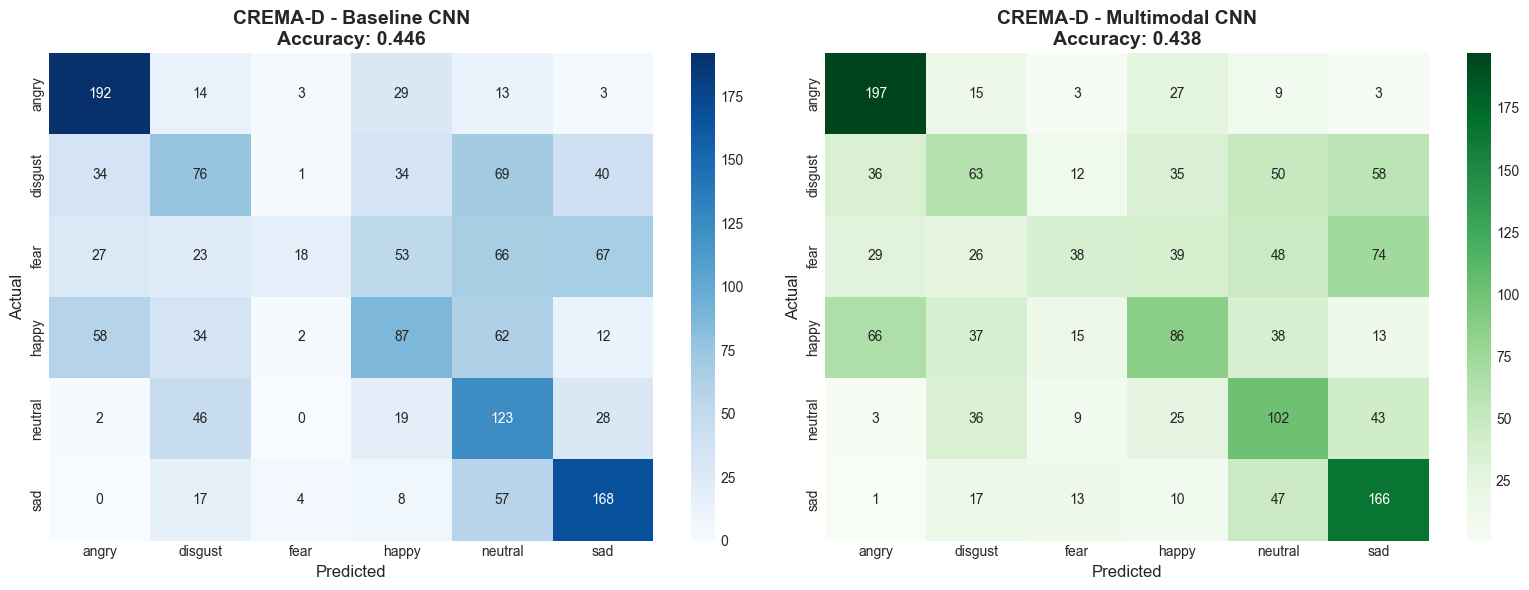

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Baseline confusion matrix
cm_baseline = confusion_matrix(y_test, y_pred_baseline)
sns.heatmap(cm_baseline, annot=True, fmt='d', cmap='Blues', 
            xticklabels=EMOTIONS, yticklabels=EMOTIONS, ax=axes[0])
axes[0].set_title(f'{DATASET_NAME} - Baseline CNN\nAccuracy: {baseline_metrics["Accuracy"]:.3f}', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Predicted', fontsize=12)
axes[0].set_ylabel('Actual', fontsize=12)

# Multimodal confusion matrix
cm_multimodal = confusion_matrix(y_test, y_pred_multimodal)
sns.heatmap(cm_multimodal, annot=True, fmt='d', cmap='Greens',
            xticklabels=EMOTIONS, yticklabels=EMOTIONS, ax=axes[1])
axes[1].set_title(f'{DATASET_NAME} - Multimodal CNN\nAccuracy: {multimodal_metrics["Accuracy"]:.3f}', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Predicted', fontsize=12)
axes[1].set_ylabel('Actual', fontsize=12)

plt.tight_layout()
save_path = f'{FIGURES_DIR}/confusion_matrices_comparison.png'
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"Saved: {save_path}")
plt.show()

## 6. ROC Curves (One-vs-Rest)

Saved: figures/roc_curves_comparison.png


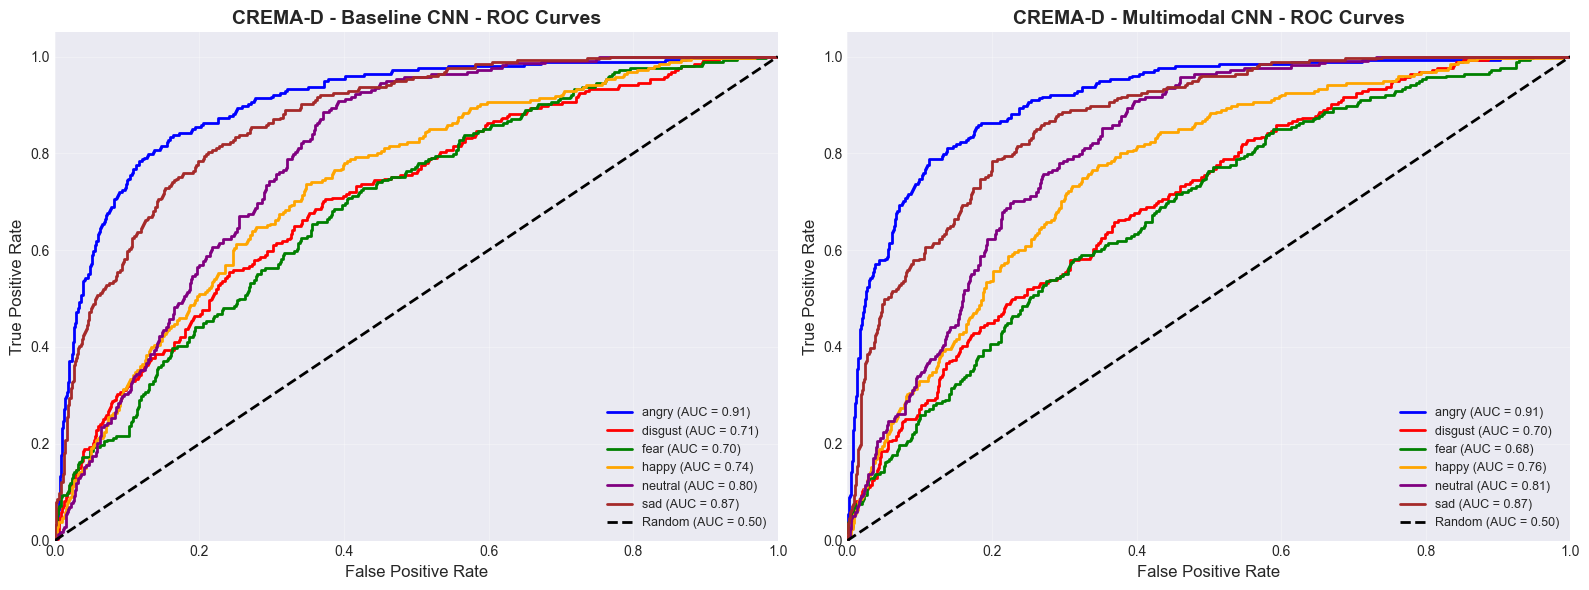


CREMA-D - ROC Analysis:
  Baseline CNN - Mean AUC: 0.788
  Multimodal CNN - Mean AUC: 0.790
  AUC Improvement: +0.20%


In [9]:
# Binarize labels for multi-class ROC
y_test_bin = label_binarize(y_test, classes=range(len(EMOTIONS)))

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Function to plot ROC curves
def plot_roc_curves(y_true_bin, y_pred_proba, ax, title):
    # Compute ROC curve and AUC for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(len(EMOTIONS)):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Plot ROC curve for each class
    colors = cycle(['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink'])
    for i, color in zip(range(len(EMOTIONS)), colors):
        ax.plot(fpr[i], tpr[i], color=color, lw=2,
                label=f'{EMOTIONS[i]} (AUC = {roc_auc[i]:.2f})')
    
    # Plot diagonal
    ax.plot([0, 1], [0, 1], 'k--', lw=2, label='Random (AUC = 0.50)')
    
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate', fontsize=12)
    ax.set_ylabel('True Positive Rate', fontsize=12)
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.legend(loc="lower right", fontsize=9)
    ax.grid(alpha=0.3)
    
    # Calculate mean AUC
    mean_auc = np.mean([roc_auc[i] for i in range(len(EMOTIONS))])
    return mean_auc

# Plot ROC for both models
mean_auc_baseline = plot_roc_curves(y_test_bin, y_pred_baseline_proba, axes[0], 
                                     f'{DATASET_NAME} - Baseline CNN - ROC Curves')
mean_auc_multimodal = plot_roc_curves(y_test_bin, y_pred_multimodal_proba, axes[1],
                                       f'{DATASET_NAME} - Multimodal CNN - ROC Curves')

plt.tight_layout()
save_path = f'{FIGURES_DIR}/roc_curves_comparison.png'
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"Saved: {save_path}")
plt.show()

print(f"\n{DATASET_NAME} - ROC Analysis:")
print(f"  Baseline CNN - Mean AUC: {mean_auc_baseline:.3f}")
print(f"  Multimodal CNN - Mean AUC: {mean_auc_multimodal:.3f}")
print(f"  AUC Improvement: {((mean_auc_multimodal - mean_auc_baseline) / mean_auc_baseline * 100):+.2f}%")

## 7. Precision-Recall Curves

Saved: figures/precision_recall_curves.png


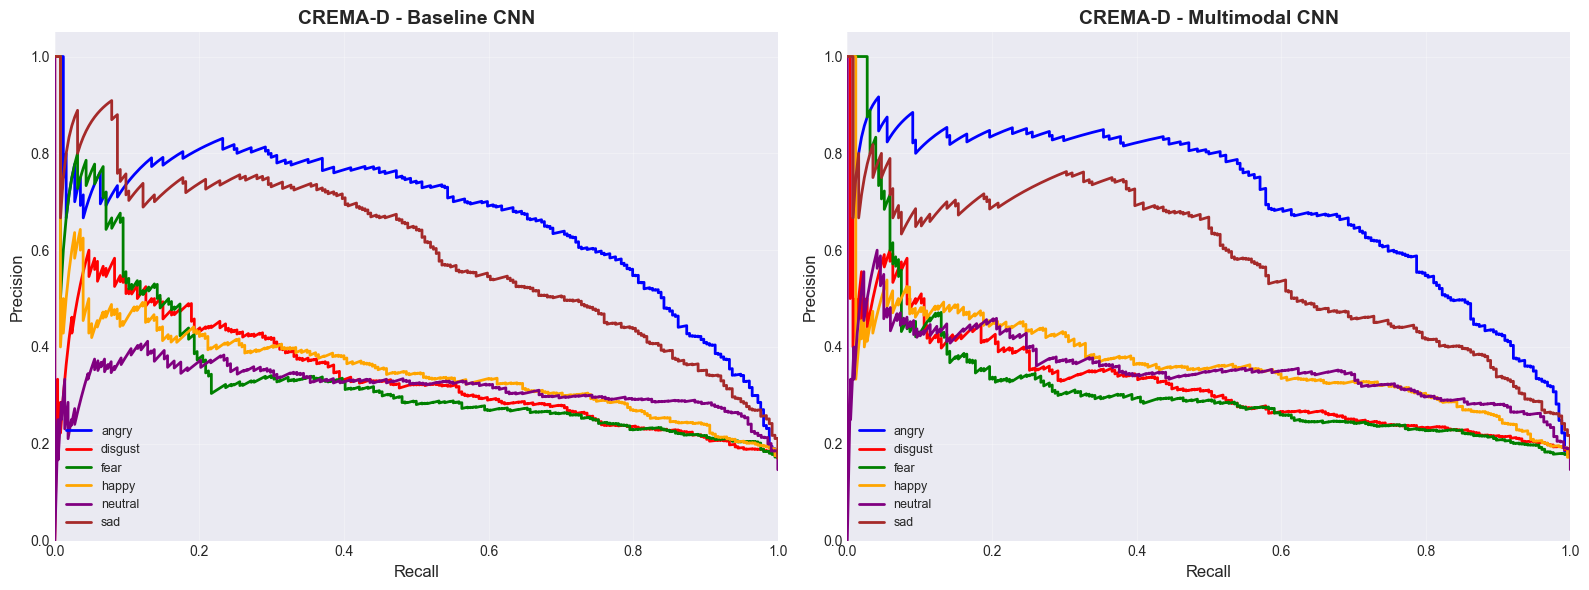

In [10]:
# Create figure with two subplots (one for each model)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

def plot_precision_recall(y_true_bin, y_pred_proba, ax, title):
    """Plot Precision-Recall curves for each emotion class."""
    colors = cycle(['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink'])
    
    # For each emotion, compute and plot its precision-recall curve
    for i, color in zip(range(len(EMOTIONS)), colors):
        # Compute precision and recall at different thresholds for this emotion (one-vs-rest)
        precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_pred_proba[:, i])
        
        # Plot the curve: x-axis = recall, y-axis = precision
        ax.plot(recall, precision, color=color, lw=2, label=EMOTIONS[i])
    
    # Configure plot
    ax.set_xlabel('Recall', fontsize=12)
    ax.set_ylabel('Precision', fontsize=12)
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.legend(loc="lower left", fontsize=9)
    ax.grid(alpha=0.3)
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])

# Plot for Baseline CNN
plot_precision_recall(y_test_bin, y_pred_baseline_proba, axes[0], 
                      f'{DATASET_NAME} - Baseline CNN')

# Plot for Multimodal CNN
plot_precision_recall(y_test_bin, y_pred_multimodal_proba, axes[1], 
                      f'{DATASET_NAME} - Multimodal CNN')

plt.tight_layout()
save_path = f'{FIGURES_DIR}/precision_recall_curves.png'
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"Saved: {save_path}")
plt.show()

## 8. Per-Class F1-Score Comparison

CREMA-D - Per-Class F1-Score Comparison:
Emotion  Baseline CNN  Multimodal CNN  Improvement
  angry      0.677249        0.672355    -0.004894
disgust      0.327586        0.281250    -0.046336
   fear      0.127660        0.220930     0.093271
  happy      0.358763        0.360587     0.001824
neutral      0.404605        0.398438    -0.006168
    sad      0.587413        0.543372    -0.044041

Saved: figures/f1_score_comparison.png

Saved: figures/f1_score_comparison.png


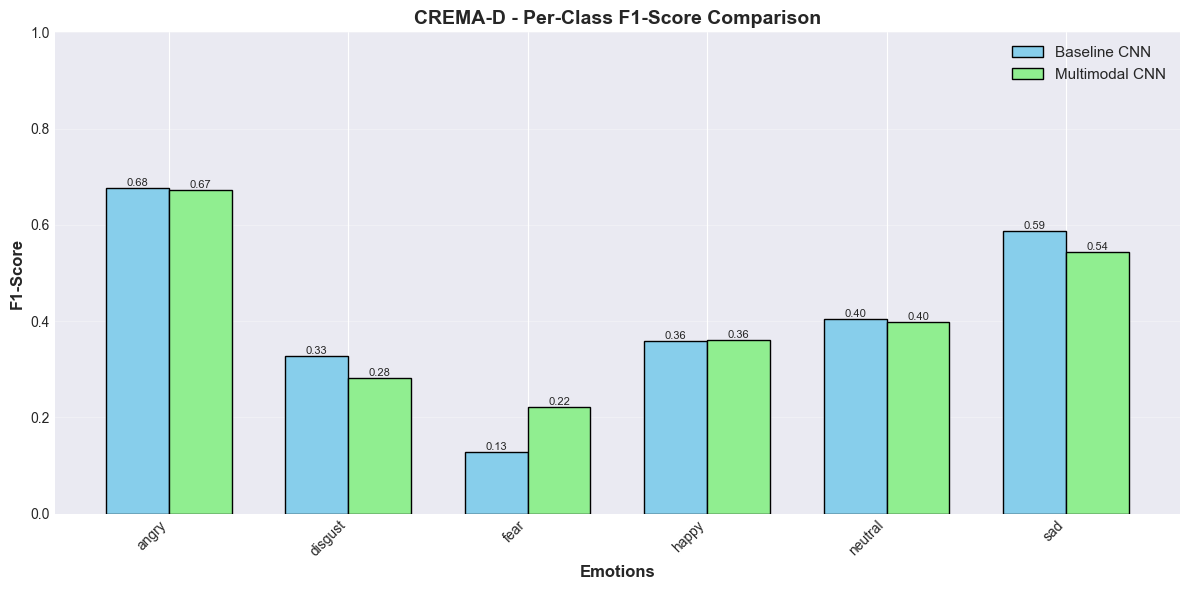

In [11]:
# Calculate per-class F1 scores
f1_baseline = f1_score(y_test, y_pred_baseline, average=None)
f1_multimodal = f1_score(y_test, y_pred_multimodal, average=None)

# Create dataframe
f1_comparison = pd.DataFrame({
    'Emotion': EMOTIONS,
    'Baseline CNN': f1_baseline,
    'Multimodal CNN': f1_multimodal,
    'Improvement': f1_multimodal - f1_baseline
})

print(f"{DATASET_NAME} - Per-Class F1-Score Comparison:")
print(f1_comparison.to_string(index=False))

# Plot comparison
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(EMOTIONS))
width = 0.35

bars1 = ax.bar(x - width/2, f1_baseline, width, label='Baseline CNN', color='skyblue', edgecolor='black')
bars2 = ax.bar(x + width/2, f1_multimodal, width, label='Multimodal CNN', color='lightgreen', edgecolor='black')

ax.set_xlabel('Emotions', fontsize=12, fontweight='bold')
ax.set_ylabel('F1-Score', fontsize=12, fontweight='bold')
ax.set_title(f'{DATASET_NAME} - Per-Class F1-Score Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(EMOTIONS, rotation=45, ha='right')
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0, 1])

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
save_path = f'{FIGURES_DIR}/f1_score_comparison.png'
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"\nSaved: {save_path}")
plt.show()